In [43]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',80)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stopwords_eng = stopwords.words('english')

# Import Data

In [4]:
tweets_df = pd.read_csv('Data/tweets_election.csv')
tweets_df.drop(tweets_df.columns[0], axis=1, inplace=True)

In [5]:
tweets_df.head()

,geo,text,user,location,Subject,state
0,NaN,After the confrontation that cost Walter Wallace Jr. his life set off prote...,wheresestela1,New Jersey,Donald Trump,New Jersey
1,NaN,"""COVID-19 is still raging. Trump is still lying.""",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas
2,NaN,"Donald Trump Jr.: ""Why aren't they talking about deaths? Oh, oh, because th...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts
3,NaN,Let’s not forget who created these problems. Tell Donald Trump his scheme to...,ajserino,"New Jersey, USA",Donald Trump,New Jersey
4,NaN,There is no greater supporter of Donald Trump in the world than Mark Zucker...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota


# NLTK text preprocess

In [6]:
def clean_tweet(tweet):
    tweet = re.sub('RT','',tweet)
    tweet = re.sub('@','',tweet)
    tweet = re.sub('#','',tweet)
    tweet = re.sub('https?://[A-Za-z0-9./]*','',tweet)
    tweet = re.sub('\n','',tweet)
    return tweet

In [7]:
# lemmatization function
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(tweet):
    lemmatized_tweet = []
    for word in tweet:
        lemmatized_tweet.append(lemmatizer.lemmatize(word, pos='v'))
    return lemmatized_tweet

# stemming function
porter = PorterStemmer()
def stem_tweet(tweet):
    stemmed_tweet = []
    for word in tweet:
        stemmed_tweet.append(porter.stem(word))
    return stemmed_tweet


# remove stopwords function
def remove_stopwords(tweet):
    tweet_witout_stops = []
    for word in tweet:
        if word not in stopwords_eng:
            tweet_witout_stops.append(word)
    return tweet_witout_stops

In [8]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_tweet)

In [9]:
# make all text lowercase
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(lambda x: x.lower())

In [10]:
# remove punctuations and numbers and emoji
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.replace("[^a-zA-z]", " ")

<ipython-input-10-7b644cf159d7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.replace("[^a-zA-z]", " ")


In [11]:
#tokenize text
tweets_df['tokenized_text'] = tweets_df['cleaned_text'].apply(lambda x: word_tokenize(x))

In [12]:
#remove stopwords
tweets_df['tokenized_text'] = tweets_df['tokenized_text'].apply(remove_stopwords)

In [13]:
#lemmatize text
tweets_df['lemmatized_text'] = tweets_df['tokenized_text']. apply(lemmatize_tweet)

In [14]:
#stem text
tweets_df['stemmed_text'] = tweets_df['lemmatized_text'].apply(stem_tweet)

In [15]:
#de tokenize text
tweets_df['lemmatized_string'] = tweets_df['lemmatized_text'].apply(lambda x: ' '.join(x))
tweets_df['stemmed_string'] = tweets_df['stemmed_text'].apply(lambda x: ' '.join(x))

In [16]:
tweets_df.head()

,geo,text,user,location,Subject,state,cleaned_text,tokenized_text,lemmatized_text,stemmed_text,lemmatized_string,stemmed_string
0,NaN,After the confrontation that cost Walter Wallace Jr. his life set off prote...,wheresestela1,New Jersey,Donald Trump,New Jersey,after the confrontation that cost walter wallace jr his life set off prote...,"[confrontation, cost, walter, wallace, jr, life, set, protests, devolved, ri...","[confrontation, cost, walter, wallace, jr, life, set, protest, devolve, riot...","[confront, cost, walter, wallac, jr, life, set, protest, devolv, riot, loot,...",confrontation cost walter wallace jr life set protest devolve riot loot lead,confront cost walter wallac jr life set protest devolv riot loot lead
1,NaN,"""COVID-19 is still raging. Trump is still lying.""",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas,covid is still raging trump is still lying,"[covid, still, raging, trump, still, lying]","[covid, still, rag, trump, still, lie]","[covid, still, rag, trump, still, lie]",covid still rag trump still lie,covid still rag trump still lie
2,NaN,"Donald Trump Jr.: ""Why aren't they talking about deaths? Oh, oh, because th...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts,donald trump jr why aren t they talking about deaths oh oh because th...,"[donald, trump, jr, talking, deaths, oh, oh, number, almost, nothing, gott]","[donald, trump, jr, talk, deaths, oh, oh, number, almost, nothing, gott]","[donald, trump, jr, talk, death, oh, oh, number, almost, noth, gott]",donald trump jr talk deaths oh oh number almost nothing gott,donald trump jr talk death oh oh number almost noth gott
3,NaN,Let’s not forget who created these problems. Tell Donald Trump his scheme to...,ajserino,"New Jersey, USA",Donald Trump,New Jersey,let s not forget who created these problems tell donald trump his scheme to...,"[let, forget, created, problems, tell, donald, trump, scheme, undermine, rig...","[let, forget, create, problems, tell, donald, trump, scheme, undermine, righ...","[let, forget, creat, problem, tell, donald, trump, scheme, undermin, right, ...",let forget create problems tell donald trump scheme undermine right vote safely,let forget creat problem tell donald trump scheme undermin right vote safe
4,NaN,There is no greater supporter of Donald Trump in the world than Mark Zucker...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,there is no greater supporter of donald trump in the world than mark zucker...,"[greater, supporter, donald, trump, world, mark, zuckerberg, one, done, elect]","[greater, supporter, donald, trump, world, mark, zuckerberg, one, do, elect]","[greater, support, donald, trump, world, mark, zuckerberg, one, do, elect]",greater supporter donald trump world mark zuckerberg one do elect,greater support donald trump world mark zuckerberg one do elect


# Clustering - Topic Modeling

## TFIDF Vectorizer

In [18]:
tfidf_vector = TfidfVectorizer(max_df=0.3, min_df=2, stop_words=stopwords_eng)

X  = tfidf_vector.fit_transform(tweets_df['lemmatized_string'])

Choosing K value

In [19]:
ssd = []

for k in range(2,10):
    
    model = KMeans(n_clusters=k)
    
    
    model.fit(X)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

Text(0.5, 1.0, 'Elbow method to find the optimal k value')

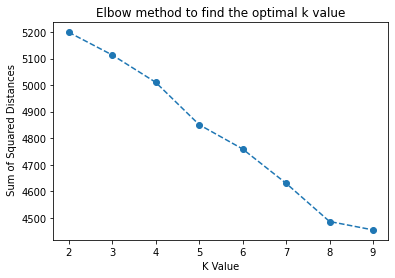

In [22]:
plt.plot(range(2,10),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")
plt.title("Elbow method to find the optimal k value")

# K-Means

In [24]:
num_clusters = 8

km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
labels = km.fit_predict(X)

In [31]:
print("Top 10 words per cluster")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print(f"Cluster #{i}")
    top_ten_words = [tfidf_vector.get_feature_names()[ind] for ind in order_centroids[i, :10]]
    print(top_ten_words)
    print('\n')

Top 10 words per cluster
Cluster #0
['vote', 'president', 'election', 'make', 'elect', 'go', 'say', 'one', 'get', 'white']


Cluster #1
['eac', 'collins', 'reelection', 'senator', 'answer', 'three', 'refuse', 'time', 'night', 'last']


Cluster #2
['animals', 'sons', 'photos', 'innocent', 'followers', 'dear', 'retweet', 'million', 'kill', 'hour']


Cluster #3
['president', 'forget', 'sight', 'lift', 'pr', 'completely', 'work', 'lose', 'pollak', 'shin']


Cluster #4
['discover', 'bogus', 'aspen', 'smear', 'martin', 'expose', 'name', 'nbc', 'fake', 'man']


Cluster #5
['business', 'active', 'document', 'later', 'fbi', 'page', 'conspiracy', 'assert', 'involve', 'son']


Cluster #6
['gym', 'high', 'fill', 'school', 'poll', 'behind', 'fan', 'fashionable', 'fascist', 'fascinate']


Cluster #7
['oh', 'almost', 'nothing', 'jr', 'deaths', 'number', 'gott', 'talk', 'covid', 'day']




In [32]:
tweets_df['cluster'] = labels

# Ploting clusters' size

Text(0.5, 0.98, 'Size of each cluster')

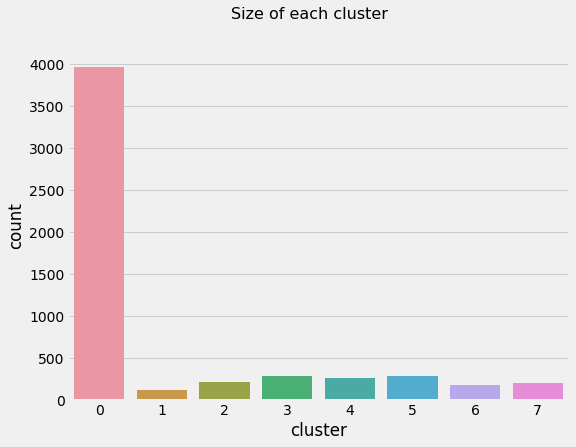

In [38]:
fig = plt.figure(figsize=(8,6))
plt.style.use('fivethirtyeight')
sns.countplot(x='cluster', data=tweets_df)
fig.suptitle('Size of each cluster', fontsize=16)

In [41]:
# top 15 tweets of cluster #0
print(tweets_df[tweets_df['cluster'] == 0].text.head(15))

0      After the confrontation that cost Walter Wallace Jr. his life set off prote...
1                                  "COVID-19 is still raging. Trump is still lying." 
3     Let’s not forget who created these problems. Tell Donald Trump his scheme to...
4      There is no greater supporter of Donald Trump in the world than Mark Zucker...
5     'A vote for Donald Trump is a vote against the very ideals upon which our de...
6      There is no greater supporter of Donald Trump in the world than Mark Zucker...
7      The same people who are outraged at AOC for slipping into a borrowed $14,00...
9     It is Friday, October 30, 2020. One citizen, I call for the removal from off...
10               Donald Trump is a dipshit. The presidency is no place for a dipshit.
11                                 "COVID-19 is still raging. Trump is still lying." 
12     Trump is going to try to make his re-election his final giant con, losing t...
13    Download the official Donald Trump for President

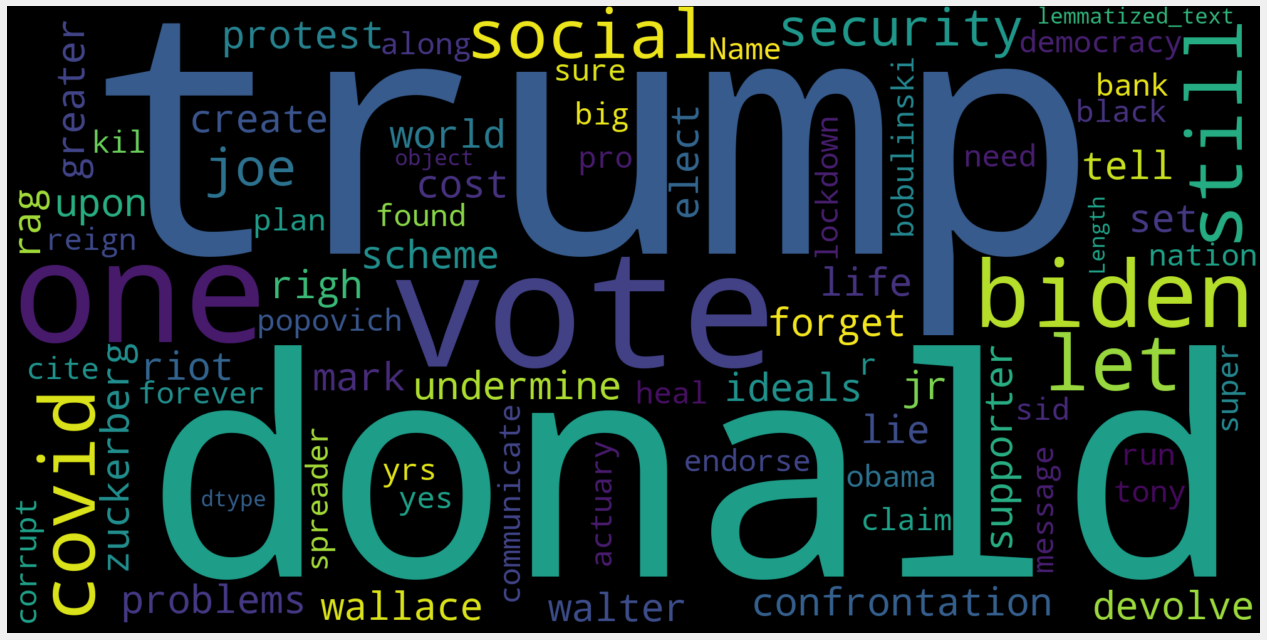

In [42]:
df = tweets_df[tweets_df['cluster'] == 0]
words = df.lemmatized_text
wordcloud = WordCloud(width=2000, height=1000, stopwords=stopwords_eng).generate(str(words))

fig = plt.figure(figsize=(20,20))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# LDA

In [93]:
lda = LatentDirichletAllocation(n_components=num_clusters, random_state=42)

In [94]:
topics = lda.fit_transform(X)

In [95]:
for index,topic in enumerate(lda.components_):
    print(f"The top 10 words for topic #{index}")
    print([tfidf_vector.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

The top 10 words for topic #0
['run', 'launder', 'investigation', 'money', 'behind', 'fill', 'gym', 'high', 'school', 'poll']


The top 10 words for topic #1
['theory', 'business', 'assert', 'son', 'later', 'document', 'involve', 'conspiracy', 'china', 'page']


The top 10 words for topic #2
['lose', 'know', 'pr', 'sight', 'lift', 'white', 'completely', 'campaign', 'work', 'people']


The top 10 words for topic #3
['back', 'dear', 'sons', 'photos', 'animals', 'innocent', 'followers', 'retweet', 'vote', 'million']


The top 10 words for topic #4
['day', 'covid', 'gott', 'number', 'talk', 'deaths', 'jr', 'almost', 'nothing', 'oh']


The top 10 words for topic #5
['help', 'make', 'greater', 'zuckerberg', 'win', 'world', 'mark', 'supporter', 'one', 'elect']


The top 10 words for topic #6
['refuse', 'collins', 'reelection', 'senator', 'ask', 'three', 'time', 'answer', 'last', 'support']


The top 10 words for topic #7
['man', 'fake', 'nbc', 'discover', 'bogus', 'smear', 'expose', 'martin',

In [96]:
topics.shape

(5553, 8)

In [97]:
topics.argmax(axis=1)

array([3, 2, 4, ..., 4, 2, 0], dtype=int64)

In [98]:
tweets_df['topic'] = topics.argmax(axis=1)

In [99]:
tweets_df.head()

,geo,text,user,location,Subject,state,cleaned_text,tokenized_text,lemmatized_text,stemmed_text,lemmatized_string,stemmed_string,cluster,topic
0,NaN,After the confrontation that cost Walter Wallace Jr. his life set off prote...,wheresestela1,New Jersey,Donald Trump,New Jersey,after the confrontation that cost walter wallace jr his life set off prote...,"[confrontation, cost, walter, wallace, jr, life, set, protests, devolved, ri...","[confrontation, cost, walter, wallace, jr, life, set, protest, devolve, riot...","[confront, cost, walter, wallac, jr, life, set, protest, devolv, riot, loot,...",confrontation cost walter wallace jr life set protest devolve riot loot lead,confront cost walter wallac jr life set protest devolv riot loot lead,0,3
1,NaN,"""COVID-19 is still raging. Trump is still lying.""",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas,covid is still raging trump is still lying,"[covid, still, raging, trump, still, lying]","[covid, still, rag, trump, still, lie]","[covid, still, rag, trump, still, lie]",covid still rag trump still lie,covid still rag trump still lie,0,2
2,NaN,"Donald Trump Jr.: ""Why aren't they talking about deaths? Oh, oh, because th...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts,donald trump jr why aren t they talking about deaths oh oh because th...,"[donald, trump, jr, talking, deaths, oh, oh, number, almost, nothing, gott]","[donald, trump, jr, talk, deaths, oh, oh, number, almost, nothing, gott]","[donald, trump, jr, talk, death, oh, oh, number, almost, noth, gott]",donald trump jr talk deaths oh oh number almost nothing gott,donald trump jr talk death oh oh number almost noth gott,7,4
3,NaN,Let’s not forget who created these problems. Tell Donald Trump his scheme to...,ajserino,"New Jersey, USA",Donald Trump,New Jersey,let s not forget who created these problems tell donald trump his scheme to...,"[let, forget, created, problems, tell, donald, trump, scheme, undermine, rig...","[let, forget, create, problems, tell, donald, trump, scheme, undermine, righ...","[let, forget, creat, problem, tell, donald, trump, scheme, undermin, right, ...",let forget create problems tell donald trump scheme undermine right vote safely,let forget creat problem tell donald trump scheme undermin right vote safe,0,1
4,NaN,There is no greater supporter of Donald Trump in the world than Mark Zucker...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,there is no greater supporter of donald trump in the world than mark zucker...,"[greater, supporter, donald, trump, world, mark, zuckerberg, one, done, elect]","[greater, supporter, donald, trump, world, mark, zuckerberg, one, do, elect]","[greater, support, donald, trump, world, mark, zuckerberg, one, do, elect]",greater supporter donald trump world mark zuckerberg one do elect,greater support donald trump world mark zuckerberg one do elect,0,5


## Ploting topics' size

Text(0.5, 0.98, 'Size of each topic')

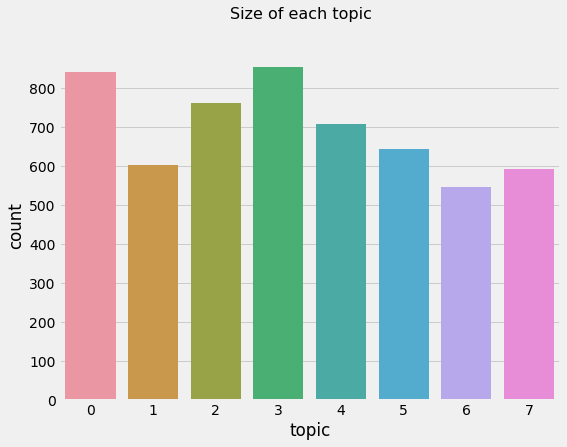

In [100]:
fig = plt.figure(figsize=(8,6))
plt.style.use('fivethirtyeight')
sns.countplot(x='topic', data=tweets_df)
fig.suptitle('Size of each topic', fontsize=16)